In [1]:
import cv2 as cv
import numpy as np
import os
import time
import matplotlib.pyplot as plt

def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img)
        plt.title(window_name)
        plt.show()

def display_1_rgb(name, img):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    plt.imshow(img[:, :, ::-1])
    plt.title(name)
    plt.show()

def display_1_gray(name, img):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    plt.imshow(img, cmap="gray")
    plt.title(name)
    plt.show()

def display_1_img(name:str, img, mode:str="rgb"):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if mode == "gray":
        plt.imshow(img, cmap="gray")
    elif mode == "fire":
        plt.imshow(img, cmap="inferno")
    else:
        plt.imshow(img[:, :, ::-1])
    plt.title(name)
    plt.show()




def plot_points(ax, V, fill='lawngreen', alpha=1):
    V_plt = np.append(V.reshape(-1), V[0,:]).reshape((-1, 2))
    ax.scatter(V[:,0], V[:,1], color=fill,
               
               linewidth=2, s=2, alpha=alpha)
    
    return ax

def display_image_with_points(img, V, title="initial state"):
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(121)
    ax.imshow(img[:, :, ::-1])
    ax.set_title(title)
    plot_points(ax, V)

##  Iterative Closest Points

The goal of this task is to estimate the template model.  Using the given image hand.jpg and set of landmark pointshandlandmarks.txt

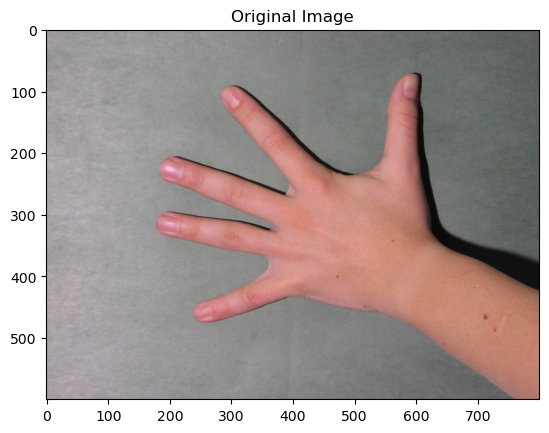

In [2]:
# set image path
path = './data/hand.jpg'
# read imgs
img = cv.imread(path)
display_1_rgb("Original Image", img)

In [3]:


def get_coordinates():
    fpath = './data/hand_landmarks.txt'
    coord_arr = []
    with open(fpath,'r') as f:
        for line in f:
            line = line.replace("(","").replace(")","").strip()
            coord = list(map(int, line.split(",")))
            coord_arr.append(coord)
    return np.array(coord_arr, dtype=np.uint64)

landmark_points = get_coordinates()


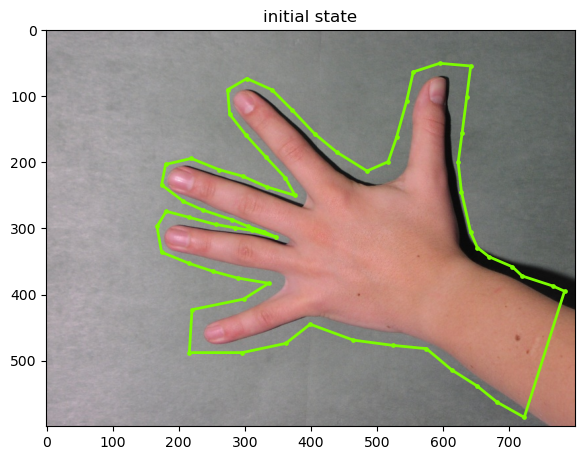

In [4]:
display_image_with_points(img, landmark_points)

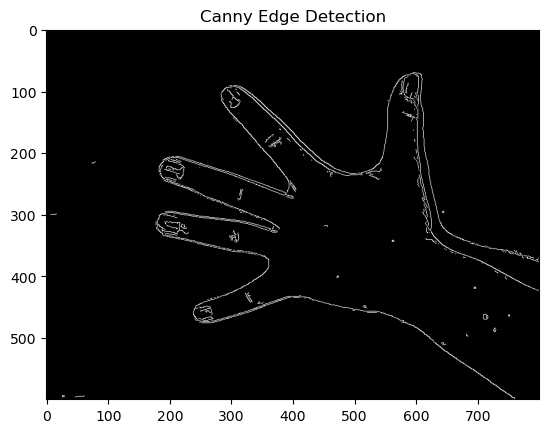

0 255


In [5]:
# find edges using Canny edge detector
edges = cv.Canny(img, 50, 100)

display_1_img("Canny Edge Detection", edges, mode="gray")
print(edges.min(), edges.max())


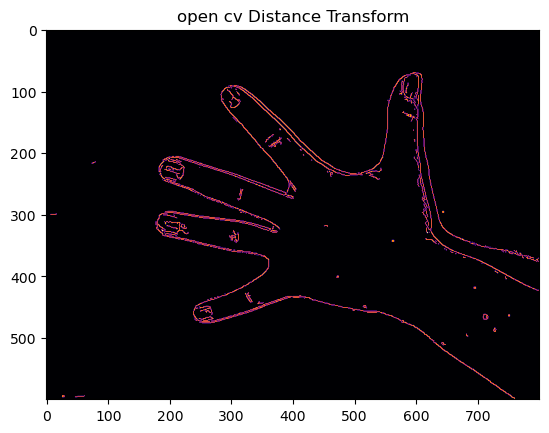

(0.0, 0.95500183)

In [6]:
distance_transf_img = cv.distanceTransform(src=np.uint8(edges), 
                             distanceType=cv.DIST_L2, 
                             maskSize=3)
display_1_img("open cv Distance Transform", distance_transf_img, mode="fire")
distance_transf_img.min(), distance_transf_img.max()

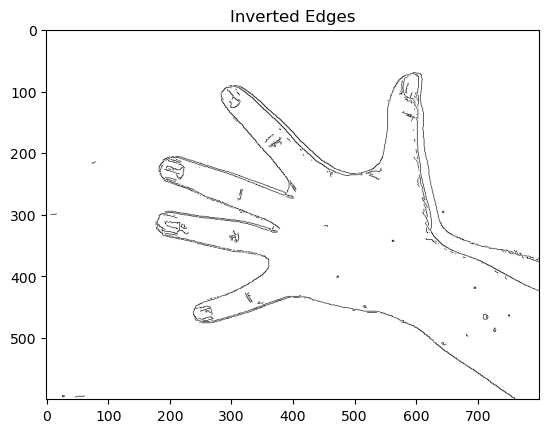

In [7]:
inverted_edges = edges.max() - edges

display_1_img("Inverted Edges", inverted_edges, mode="gray")

Let's invert edges

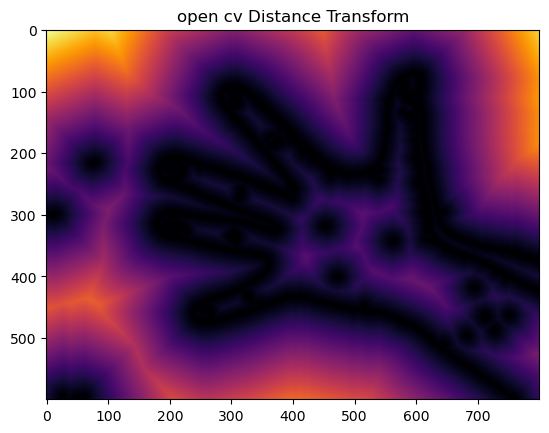

(0.0, 237.76654)

In [8]:
distance_transf_img = cv.distanceTransform(src=np.uint8(inverted_edges), 
                             distanceType=cv.DIST_L2, 
                             maskSize=3)
display_1_img("open cv Distance Transform", distance_transf_img, mode="fire")
distance_transf_img.min(), distance_transf_img.max()

In [9]:
gx, gy = np.gradient(distance_transf_img)

In [10]:
# correspondences
def get_correspondences(dist_transf_img, gx, gy):
    magnitude = np.sqrt(gx**2 + gy**2) + 1
    grad_prod = gx*gy + 1
    X = dist_transf_img/magnitude *grad_prod
    return X


    
correspondences = get_correspondences(distance_transf_img, gx, gy)
    

In [11]:
gx, gy = np.gradient(distance_transf_img)

In [12]:
new_lm_points = []
for lm_point in landmark_points:
    i, j = lm_point
    
    D = distance_transf_img[j, i]
    G_x = gx[j, i]
    G_y = gy[j, i]
    new_i = i + D*G_x
    new_j = j + D*G_y
    new_lm_points.append([new_i, new_j])

new_lm_points = np.array(new_lm_points)
new_lm_points = np.around(new_lm_points).astype(np.int32)

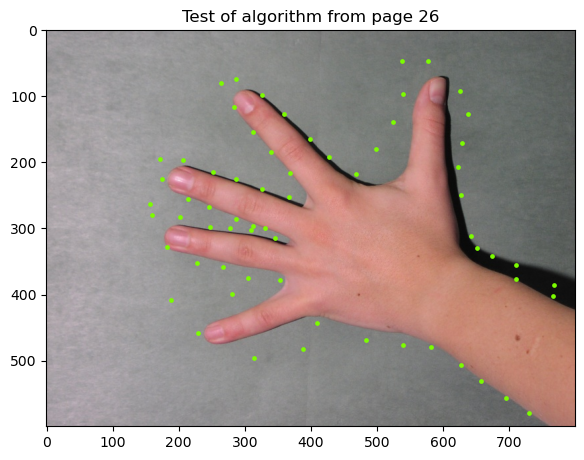

In [13]:
display_image_with_points(img, new_lm_points, title="Test of algorithm from page 26")

In [14]:


def get_transformation(point_cloud_1, closest_points):
    # Calculate the transformation that aligns point_cloud_1 and closest_points
    # This can be done using Singular Value Decomposition (SVD)
    centered_points_1 = point_cloud_1 - np.mean(point_cloud_1, axis=0)
    centered_points_2 = closest_points - np.mean(closest_points, axis=0)
    W = np.dot(centered_points_1.T, centered_points_2)
    U, _, Vt = np.linalg.svd(W)
    R = np.dot(U, Vt)
    t = np.mean(closest_points, axis=0) - np.dot(np.mean(point_cloud_1, axis=0), R)
    return R, t



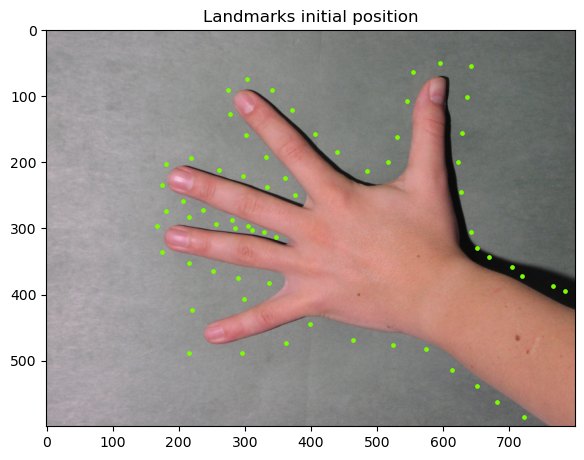

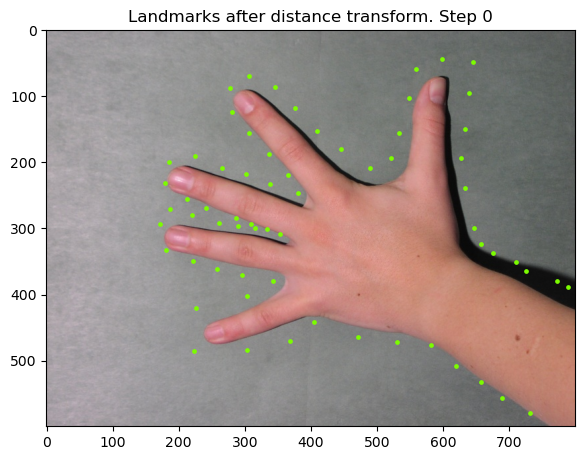

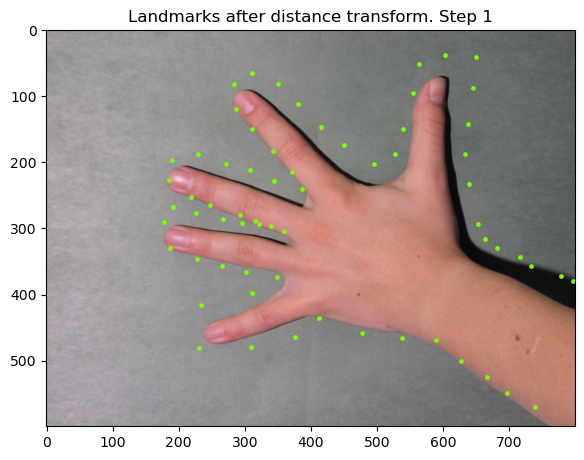

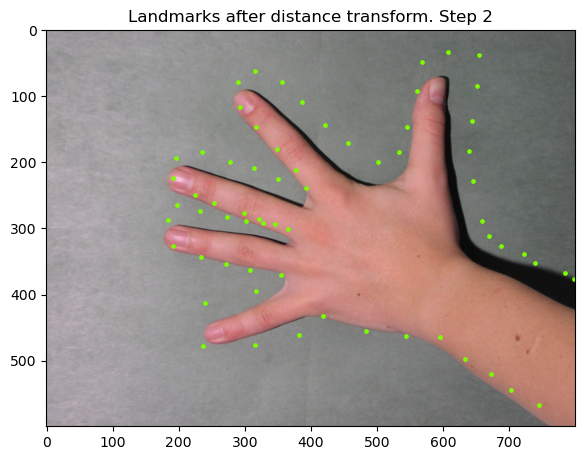

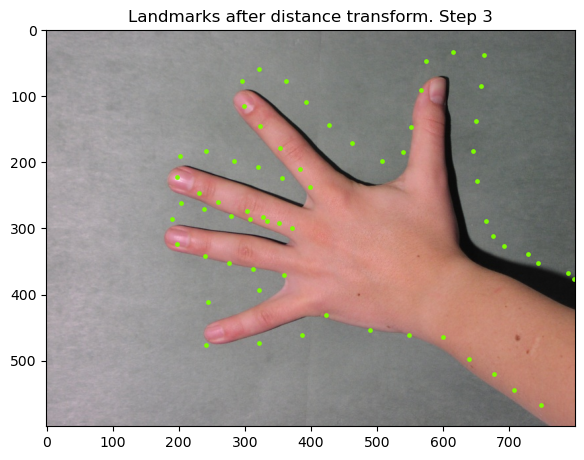

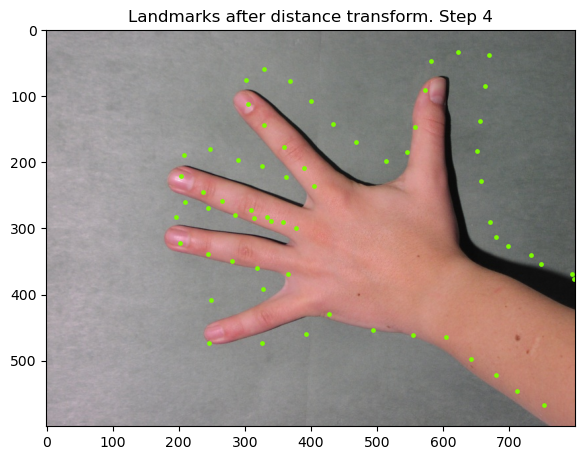

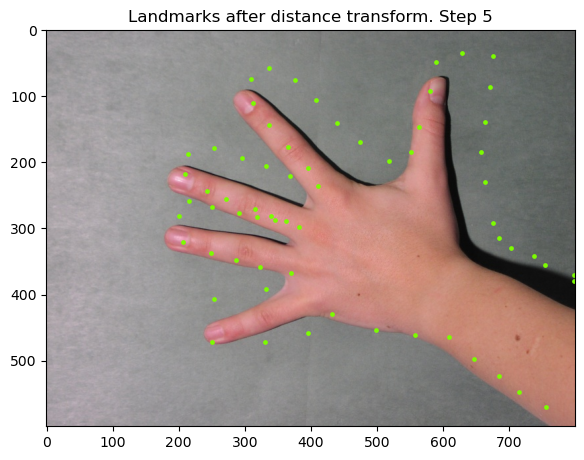

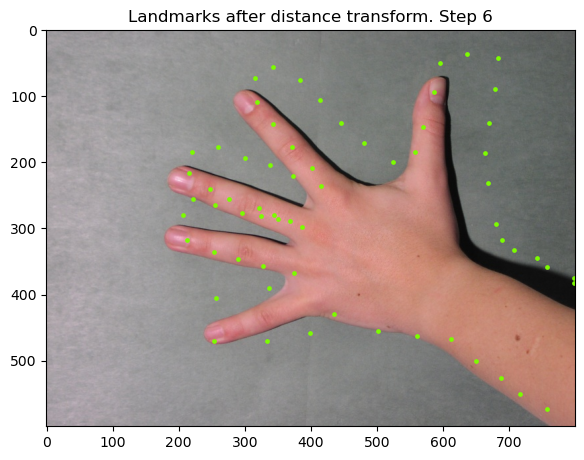

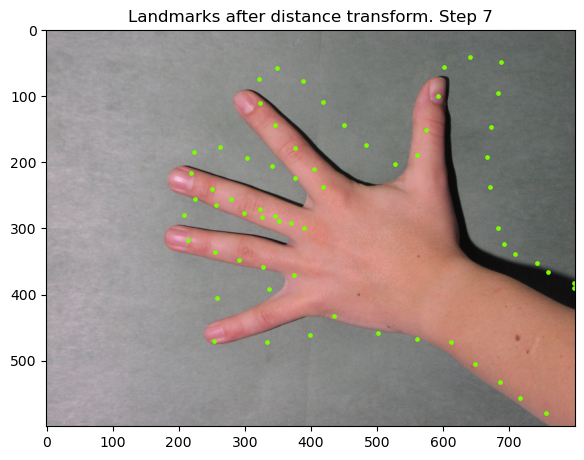

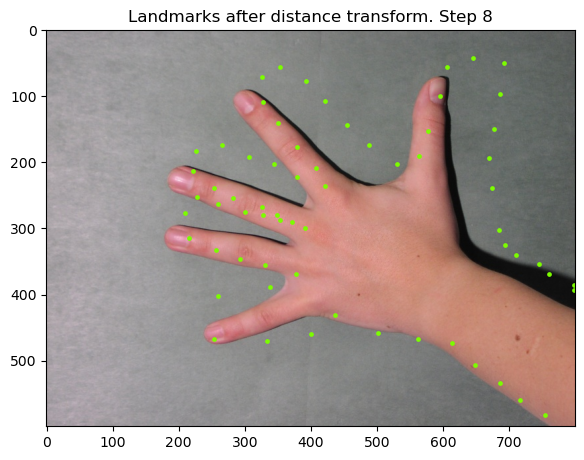

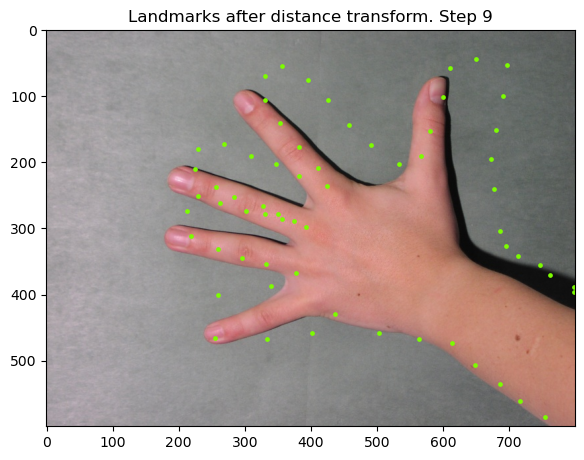

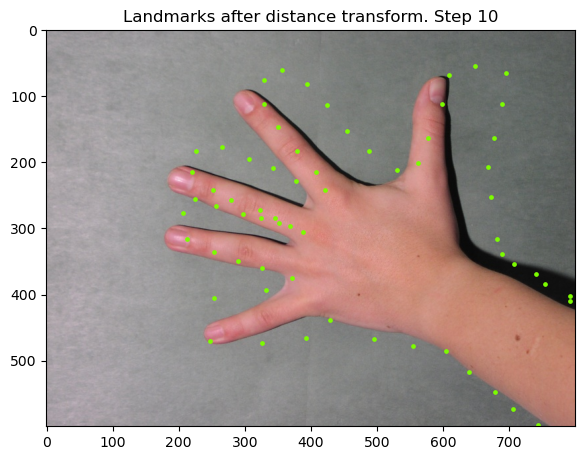

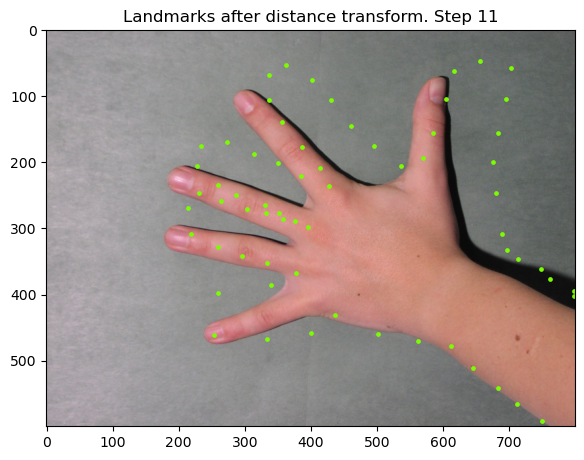

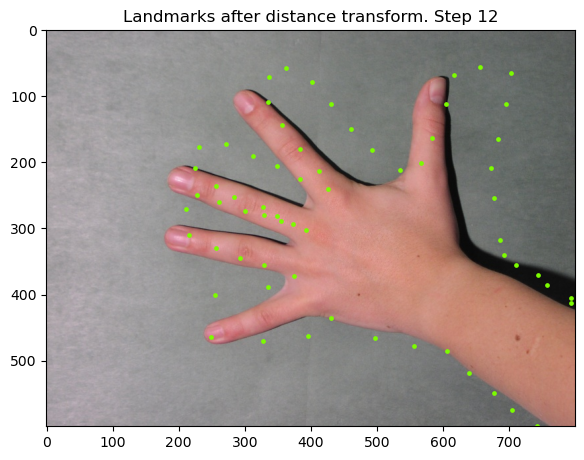

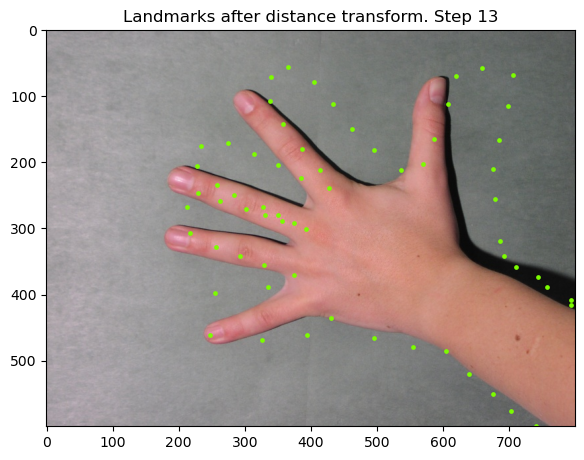

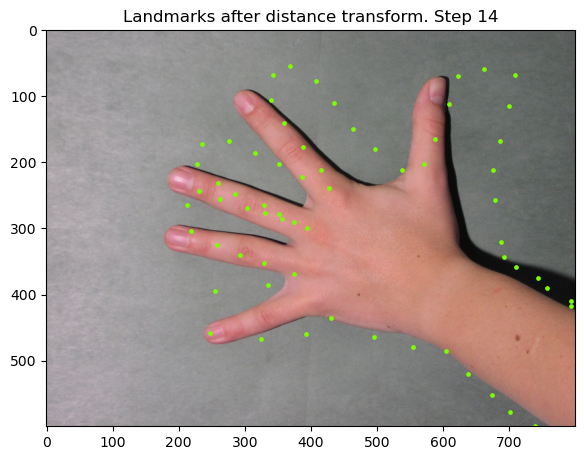

In [15]:
lm_points = np.array(landmark_points)
display_image_with_points(img, lm_points, title="Landmarks initial position")
M = np.eye(landmark_points.shape[1])
t = np.zeros(landmark_points.shape[1])
for iter in range(15):
    closest_points = []
    
    # find the closest points to the landmarks (stupid way with for loop)
    for lm_point in lm_points:
        i, j = lm_point
    
        D = distance_transf_img[j, i]
        G_x = gx[j, i]
        G_y = gy[j, i]
        new_i = i - D*G_x 
        new_j = j - D*G_y 
        closest_points.append([new_i, new_j])


    new_M, new_t = get_transformation(lm_points, closest_points)

    # Update the transformation
    # M = np.dot(new_M, M)
    # t = np.dot(new_M, t) + new_t
    M = new_M
    t = new_t



    result_points = []
    # Apply the transformation to the landmarks (stupid way with for loop)
    for point in lm_points:
        new_point = np.around(np.dot(M, point) + t).astype(np.int32)
        result_points.append(new_point)
        
        

    result_points = np.array(result_points)
    lm_points = result_points
    
    # Clip the points to the image size
    lm_points = lm_points.T
    lm_points[0] = np.clip(lm_points[0], 0, img.shape[1]-1)
    lm_points[1] = np.clip(lm_points[1], 0, img.shape[0]-1)
    lm_points = lm_points.T

    display_image_with_points(img, lm_points, title="Landmarks after distance transform. Step {}".format(iter))


    

In [16]:
M, t

(array([[ 0.99996849, -0.00793807],
        [ 0.00793807,  0.99996849]]),
 array([ 3.13581153, -4.69555947]))

Something is wrong with the transformation. Points fly away ;(